In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import copy

In [ ]:
np.nansum(grid_area_msk)

In [18]:
# Option
dave_mc=False

# Get the permafrost mask for cont and discont permfrost
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/surfdata_05x05.nc'
nclu=NetCDFFile(path,'r')
pf = nclu.variables['PFMASK'][:]
nclu.close()
pfmask = ma.masked_where(pf<=0, pf)

# Open STT for 0D
# 1860s
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/tau_0d_1860s.nc'
nclu=NetCDFFile(path,'r')
stt_0d_1860 = nclu.variables['tau_1m'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()
stt_0d_1860[stt_0d_1860>1000] = np.float('nan')

# 2000s
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/tau_0d_2000s.nc'
nclu=NetCDFFile(path,'r')
stt_0d_2000 = nclu.variables['tau_1m'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()
stt_0d_2000[stt_0d_1860>2000] = np.float('nan')

# Open STT for 1D
# 1860s
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/tau_1d_1860.nc'
nclu=NetCDFFile(path,'r')
stt_1dtop_1860 = nclu.variables['tau_top'][:]
stt_1dsub_1860 = nclu.variables['tau_sub'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()
# stt_1dtop_1860[stt_1dtop_1860>2000] = np.float('nan')
# stt_1dsub_1860[stt_1dsub_1860>2000] = np.float('nan')

path='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_1d/Global_1DSBGC.bgc-yearly-3d_1861.nc'
nclu=NetCDFFile(path,'r')
soc_lev_1860 = nclu.variables['soil_c_lev'][:]
nclu.close()

# 2000s
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/tau_1d_2000.nc'
nclu=NetCDFFile(path,'r')
stt_1dtop_2000 = nclu.variables['tau_top'][:]
stt_1dsub_2000 = nclu.variables['tau_sub'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()
# stt_1dtop_2000[stt_1dtop_2000>2000] = np.float('nan')
# stt_1dsub_2000[stt_1dsub_2000>2000] = np.float('nan')

path='/data/jain1/d/sshu3/SBGC_regional_results/SBGC_1d/Global_1DSBGC.bgc-yearly-3d_2010.nc'
nclu=NetCDFFile(path,'r')
soc_lev_2000 = nclu.variables['soil_c_lev'][:]
nclu.close()

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Open the histel and histosol fraction map to mask peatland 
respath = '/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/'
fhistosol = 'NCSCDv2_Circumpolar_WGS84_histosol_pct_05deg.nc'
fhistel = 'NCSCDv2_Circumpolar_WGS84_histel_pct_05deg.nc'

fp=respath+fhistosol
nclu_his=NetCDFFile(fp,'r')
histosol = nclu_his.variables['NCSCDv2'][:]
latnc3 = nclu_his.variables['lat'][:]
lonnc3 = nclu_his.variables['lon'][:]
frac_histosol = copy.deepcopy(histosol)
histosol[histosol<=0] = 0
histosol[histosol>0] = 1
nclu_his.close()
#histosol = np.flipud(histosol)

fp=respath+fhistel
nclu_his=NetCDFFile(fp,'r')
histel = nclu_his.variables['NCSCDv2'][:]
frac_histel = copy.deepcopy(histel)
histel[histel<=0] = 0
histel[histel>0] = 1
nclu_his.close()

frac_peat = frac_histosol/100. + frac_histel/100.

# Add a new mask with considering peat fraction and non-permafrost region
histel_full = ma.zeros((360,720))
histel_full[0:111,:] = histel
temp = copy.deepcopy(histel_full[:, 0:360])
histel_full[:, 0:360] = histel_full[:, 360:720]
histel_full[:, 360:720] = temp
histel_full = histel_full[::-1,:]
nopeat_mask = ma.masked_where(histel_full>0, another_mask)

# SOC weighted STT
soc_top_1860 = np.sum(soc_lev_1860[0:5,:,:], 0)
soc_top_2000 = np.sum(soc_lev_2000[0:5,:,:], 0)
soc_sub_1860 = np.sum(soc_lev_1860[5:7,:,:], 0)+0.3*soc_lev_1860[7,:,:]
soc_sub_2000 = np.sum(soc_lev_2000[5:7,:,:], 0)+0.3*soc_lev_2000[7,:,:]

wt_top_1860 = soc_top_1860/(soc_top_1860+soc_sub_1860)
wt_sub_1860 = soc_sub_1860/(soc_top_1860+soc_sub_1860)
wt_top_2000 = soc_top_2000/(soc_top_2000+soc_sub_2000)
wt_sub_2000 = soc_sub_2000/(soc_top_2000+soc_sub_2000)

stt_1d_1860 = wt_top_1860*stt_1dtop_1860 + wt_sub_1860*stt_1dsub_1860
stt_1d_2000 = wt_top_2000*stt_1dtop_2000 + wt_sub_1860*stt_1dsub_2000

dstt_1d = stt_1d_2000 - stt_1d_1860
dstt_1d_top = stt_1dtop_2000 - stt_1dtop_1860
dstt_1d_sub = stt_1dsub_2000 - stt_1dsub_1860
dstt_0d = stt_0d_2000 - stt_0d_1860


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


In [ ]:
plt.imshow(another_mask.mask)

In [ ]:
plt.imshow(nopeat_mask_new)

In [6]:
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent
stt_1d_1860_perm = copy.deepcopy(stt_1d_1860)
stt_1d_1860_perm.mask = pfmask.mask
stt_1d_2000_perm = copy.deepcopy(stt_1d_2000)
stt_1d_2000_perm.mask = pfmask.mask

stt_1d_top_1860_perm = copy.deepcopy(stt_1dtop_1860)
stt_1d_top_1860_perm.mask = pfmask.mask
stt_1d_top_2000_perm = copy.deepcopy(stt_1dtop_2000)
stt_1d_top_2000_perm.mask = pfmask.mask

stt_1d_sub_1860_perm = copy.deepcopy(stt_1dsub_1860)
stt_1d_sub_1860_perm.mask = pfmask.mask
stt_1d_sub_2000_perm = copy.deepcopy(stt_1dsub_2000)
stt_1d_sub_2000_perm.mask = pfmask.mask

stt_0d_1860_perm = copy.deepcopy(stt_0d_1860)
stt_0d_1860_perm.mask = pfmask.mask
stt_0d_2000_perm = copy.deepcopy(stt_0d_2000)
stt_0d_2000_perm.mask = pfmask.mask

dstt_1d_perm = copy.deepcopy(dstt_1d)
dstt_0d_perm = copy.deepcopy(dstt_0d)

dstt_1d_perm = copy.deepcopy(dstt_1d)
dstt_0d_perm = copy.deepcopy(dstt_0d)

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val = np.ones((nlat, nlon))*float("nan")
val_0d = np.ones((nlat, nlon))*float("nan")
val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        # ISAM-1D estimation for 1860s
        val[i,j] = stt_1d_1860_perm[i,j] * grid_area[i,j]
        # ISAM-0D estimation for 1860s
        val_0d[i,j] = stt_0d_1860_perm[i,j] * grid_area[i,j]

grid_area_msk = ma.masked_array(grid_area, mask=pfmask.mask)

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: converting a masked element to nan.


In [ ]:
grid_area_msk = ma.masked_array(grid_area, mask=pfmask.mask)

In [ ]:
# Get the total amount of NCSCD SOC by excluding histosol and histel
total_histosol = 69.1
total_histel = 49.3
val_0d[val_0d<0] = 0
# Mean STT
isam_0d_all = np.nansum(val_0d)/np.nansum(grid_area_msk)
isam_1d_all = np.nansum(val)/np.nansum(grid_area_msk)

print('ISAM-1D estimated STT ...')
print(isam_1d_all)
print('ISAM-0D estimated STT ...')
print(isam_0d_all)

In [ ]:
# NCSCD SOC stock ...
# 474.9181063795683
# NCSCD SOC stock without peat ...
# 356.51810637956834

# ISAM-1D estimated contemporary SOC stock ...
# 353.52246987372865
# ISAM-0D estimated contemporary SOC stock ...
# 180.7218003115083
# ISAM-1D estimated preindustrail SOC stock ...
# 343.61655160412346
# ISAM-0D estimated preindustrail SOC stock ...
# 177.30753527613672

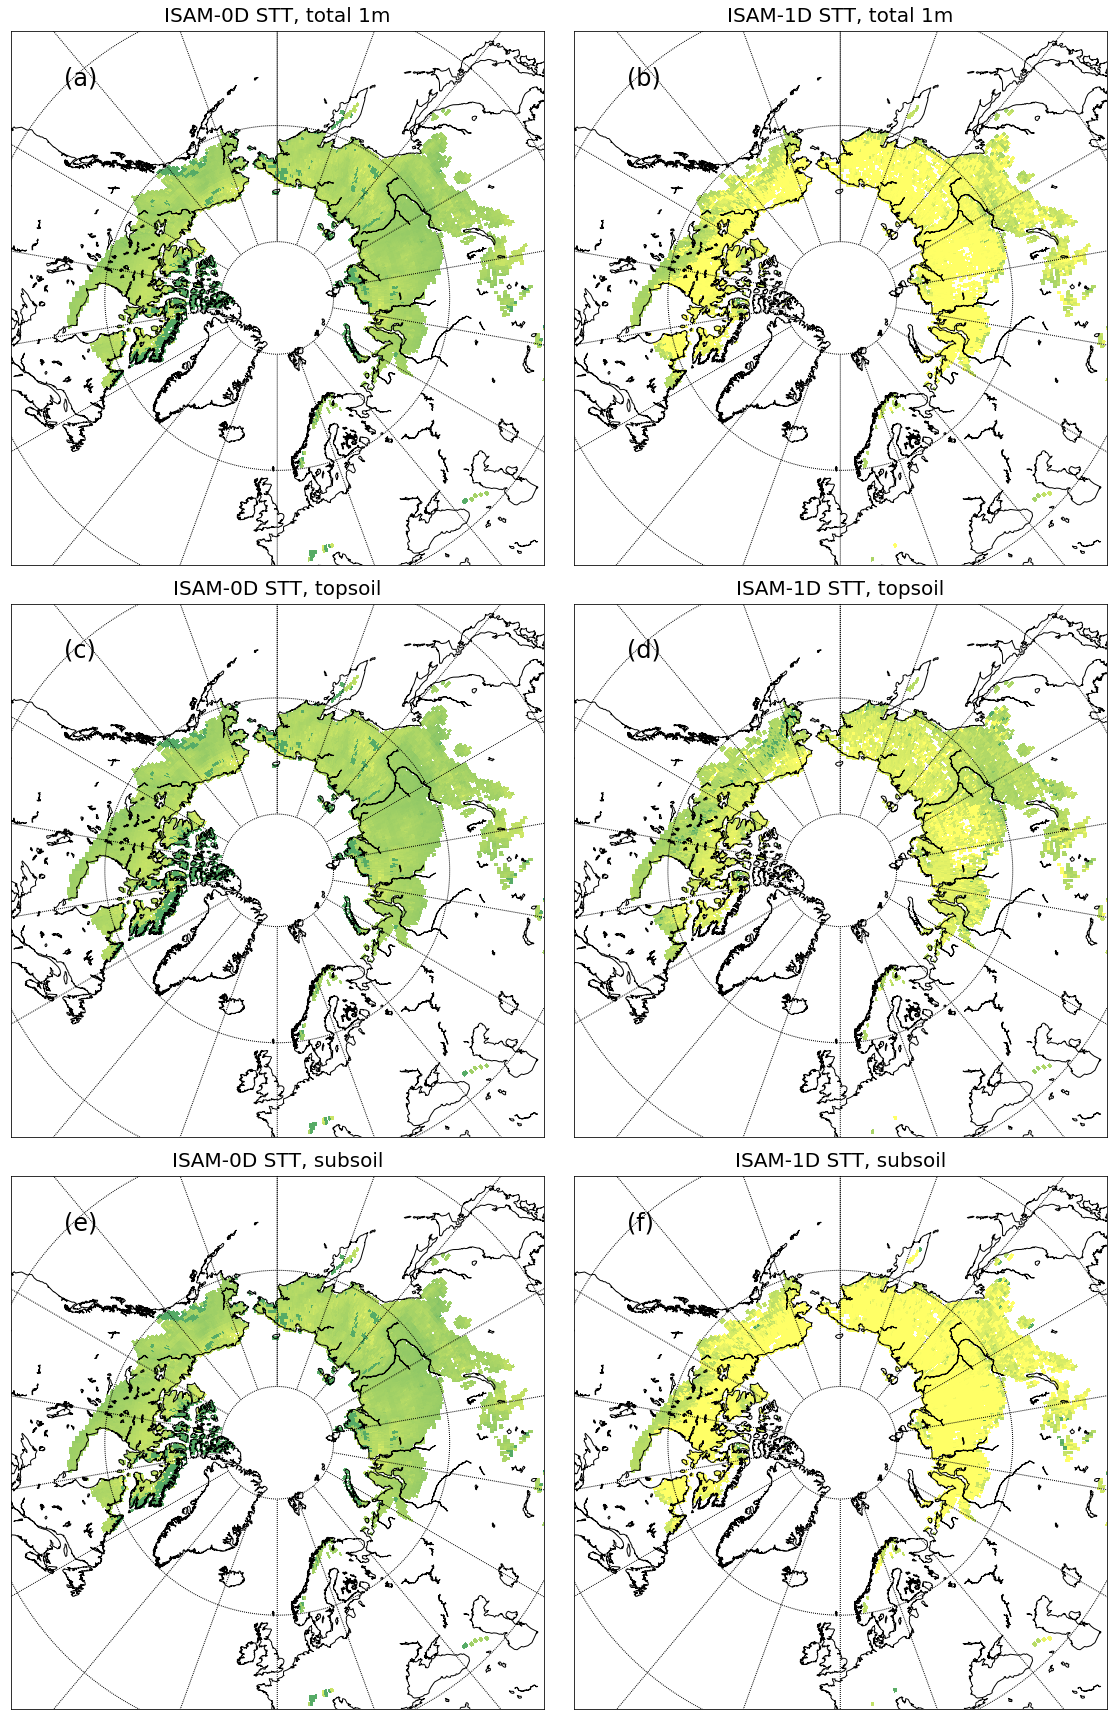

In [28]:
# Mask all regions outside the northern permafrost extent
dstt_1d_perm = copy.deepcopy(dstt_1d)
dstt_1d_perm.mask = another_mask.mask
dstt_0d_perm = copy.deepcopy(dstt_0d)
dstt_0d_perm.mask = another_mask.mask

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(16,24))

#ax1 = fig.add_subplot(331)
ax1 = fig.add_subplot(321)
ax1.set_title("ISAM-0D STT, total 1m",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,stt_0d_1860_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=2000.),cmap=plt.cm.summer) # use log color scale,
#cbar = map.colorbar(cs1,ticks=[1, 10, 100, 1000, 2000],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax2 = fig.add_subplot(322)
ax2.set_title("ISAM-1D STT, total 1m",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,stt_1d_1860_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=2000.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[1, 10, 100, 1000, 2000],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax3 = fig.add_subplot(323)
ax3.set_title("ISAM-0D STT, topsoil",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,stt_0d_1860_perm[:,:],
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.bwr) # use log color scale,
              norm=colors.LogNorm(vmin=1,vmax=2000.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs3,ticks=[1, 10, 100, 1000, 2000],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=18)

ax4 = fig.add_subplot(324)
ax4.set_title("ISAM-1D STT, topsoil",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,stt_1d_top_1860_perm[:,:],
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.bwr) # use log color scale,
              norm=colors.LogNorm(vmin=1,vmax=2000.),cmap=plt.cm.summer) # use log color scale,
#cbar = map.colorbar(cs4,ticks=[1, 10, 100, 1000, 2000],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=18)

ax1 = fig.add_subplot(325)
ax1.set_title("ISAM-0D STT, subsoil",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs1 = map.pcolormesh(x,y,stt_0d_1860_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=2000.),cmap=plt.cm.summer) # use log color scale,
#cbar = map.colorbar(cs1,ticks=[1, 10, 100, 1000, 2000],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(e)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax2 = fig.add_subplot(326)
ax2.set_title("ISAM-1D STT, subsoil",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,stt_1d_sub_1860_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=2000.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs2,ticks=[1, 10, 100, 1000, 2000],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
plt.annotate('(f)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

plt.tight_layout()
#plt.show()
plt.savefig('./figures/fig7.png',dpi=300)

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


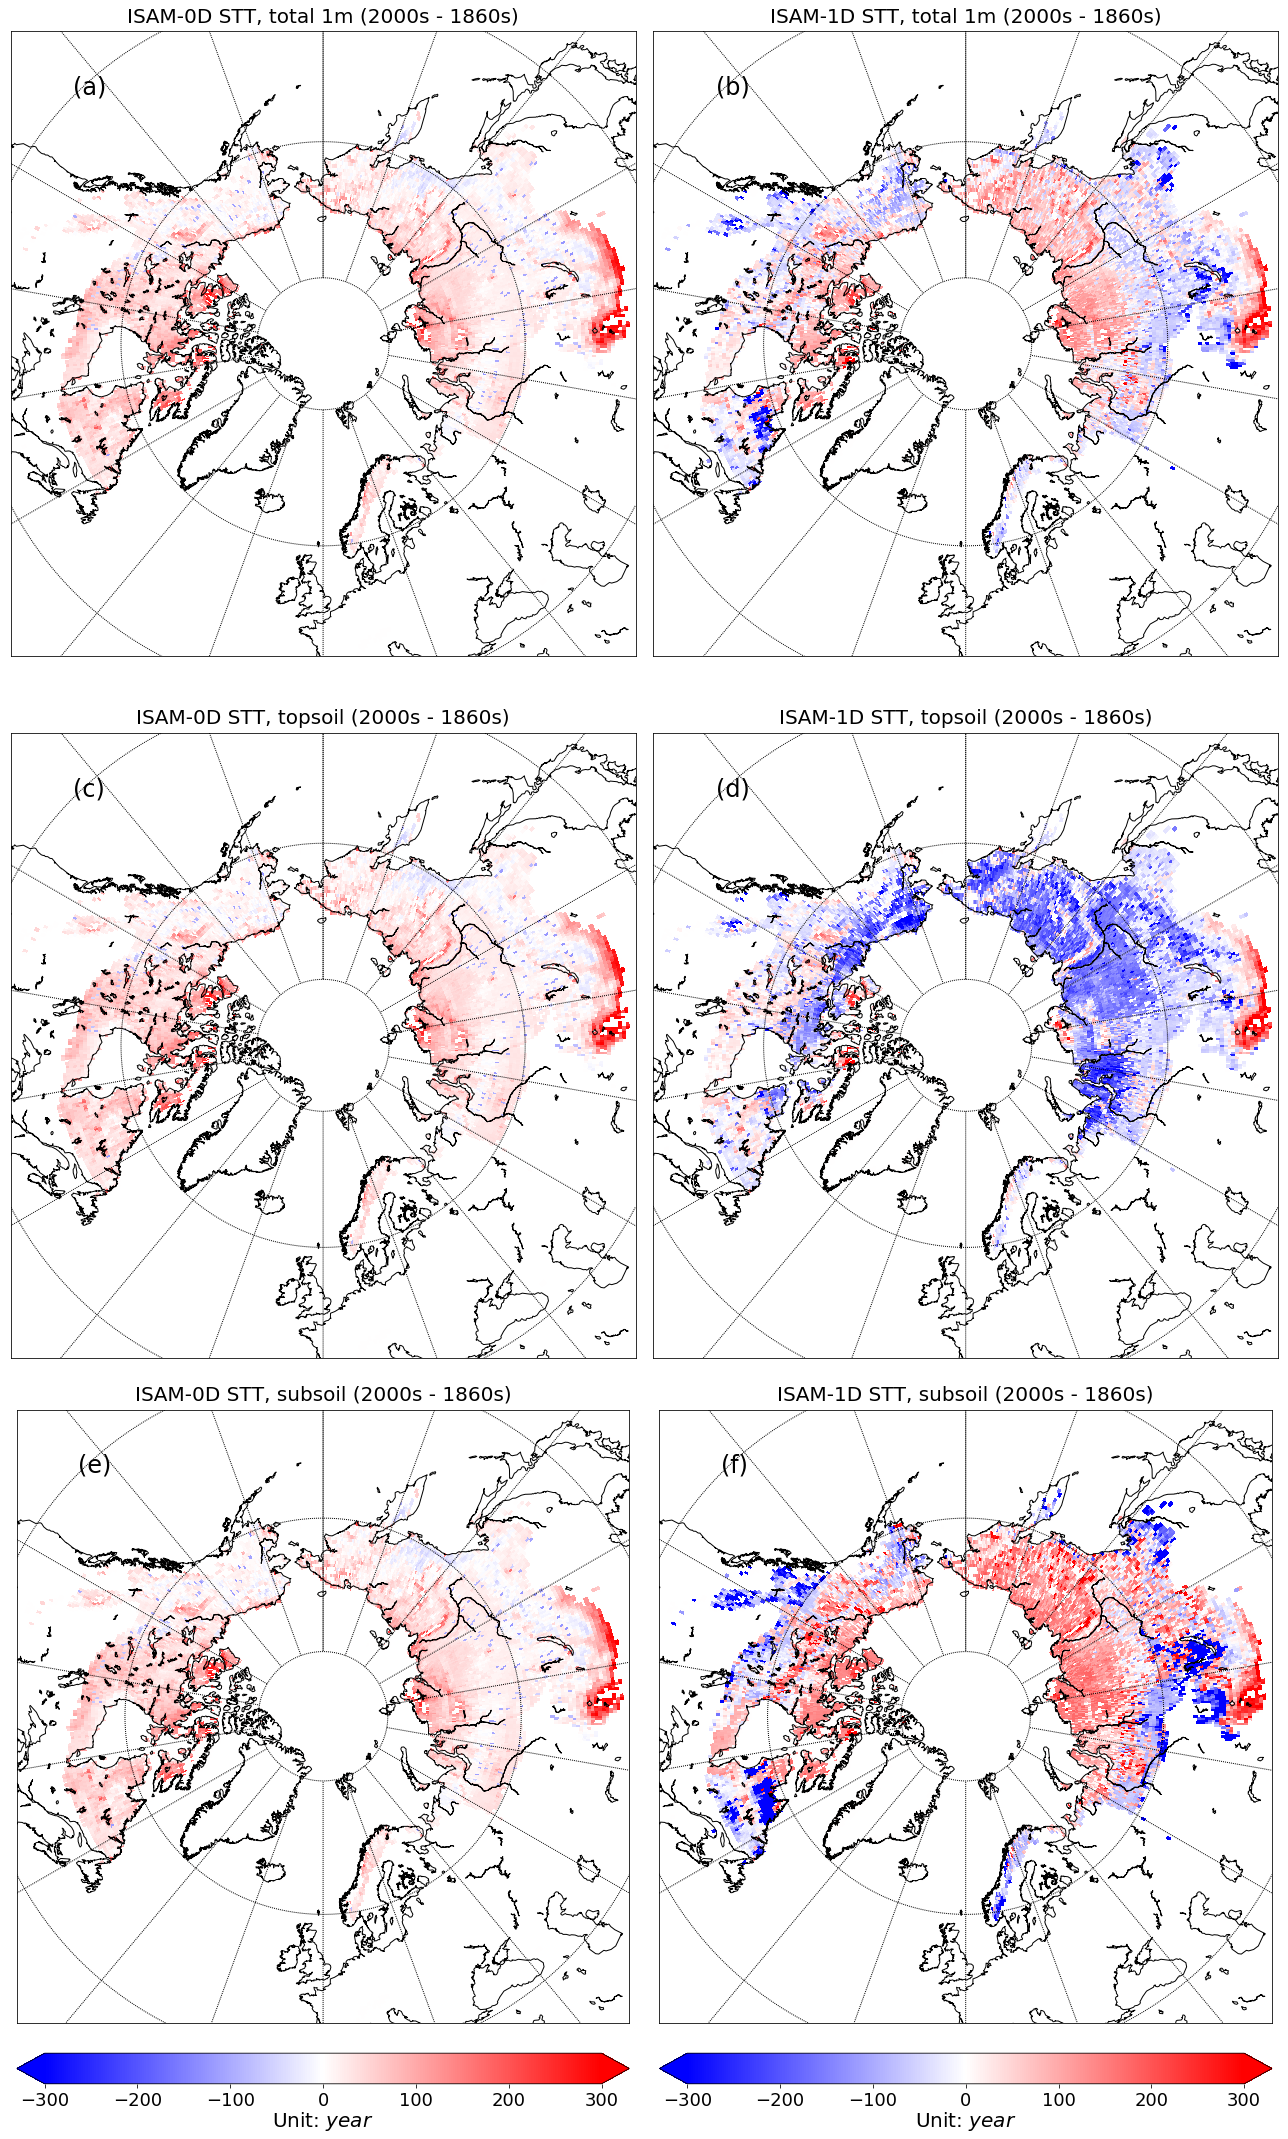

In [25]:
# Mask all regions outside the northern permafrost extent
dstt_1d_perm = copy.deepcopy(dstt_1d)
dstt_1d_perm.mask = another_mask.mask
dstt_1d_top_perm = copy.deepcopy(dstt_1d_top)
dstt_1d_top_perm.mask = another_mask.mask
dstt_1d_sub_perm = copy.deepcopy(dstt_1d_sub)
dstt_1d_sub_perm.mask = another_mask.mask

dstt_0d_perm = copy.deepcopy(dstt_0d)
dstt_0d_perm.mask = another_mask.mask

# Glacier grids are excluded since only tiny SOC are there
dstt_0d_perm[dstt_0d_perm>300] = 0.

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(18,30))

ax1 = fig.add_subplot(321)
ax1.set_title("ISAM-0D STT, total 1m (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dstt_0d_perm[:,:],
              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.bwr) # use log color scale,      
#cbar = map.colorbar(cs3,ticks=[-300, -200, -100, 0, 100, 200, 300],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax2 = fig.add_subplot(322)
ax2.set_title("ISAM-1D STT, total 1m (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dstt_1d_perm[:,:],
              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.bwr) # use log color scale,      
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs3,ticks=[-300, -200, -100, 0, 100, 200, 300],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=22)

ax3 = fig.add_subplot(323)
ax3.set_title("ISAM-0D STT, topsoil (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dstt_0d_perm[:,:],
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.bwr) # use log color scale,
              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#cbar = map.colorbar(cs3,ticks=[-300, -200, -100, 0, 100, 200, 300],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=18)

ax4 = fig.add_subplot(324)
ax4.set_title("ISAM-1D STT, topsoil (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dstt_1d_top_perm[:,:],
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.bwr) # use log color scale,
              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.bwr) # use log color scale,                     
#cbar = map.colorbar(cs4,ticks=[-300, -200, -100, 0, 100, 200, 300],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.tick_params(labelsize=18)

ax4 = fig.add_subplot(325)
ax4.set_title("ISAM-0D STT, subsoil (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dstt_0d_perm[:,:],
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.bwr) # use log color scale,
              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.bwr) # use log color scale,                     
cbar = map.colorbar(cs4,ticks=[-300, -200, -100, 0, 100, 200, 300],location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(e)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=18)

ax4 = fig.add_subplot(326)
ax4.set_title("ISAM-1D STT, subsoil (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dstt_1d_sub_perm[:,:],
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.bwr) # use log color scale,
              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.bwr) # use log color scale,                     
cbar = map.colorbar(cs4,ticks=[-300, -200, -100, 0, 100, 200, 300],location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(f)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
#plt.show()
plt.savefig('./figures/fig9.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

plt.show()
#plt.savefig('./figures/fig7.png',dpi=300)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
